In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# from nltk.stem import SnowballStemmerSnowballStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
sms = pd.read_csv('../data/sms-spam.csv',delimiter=',',encoding='latin-1')

sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [3]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Now let's create new feature "message length" and plot it to see if it's of any interest

In [5]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10236f198>,
      dtype=object)

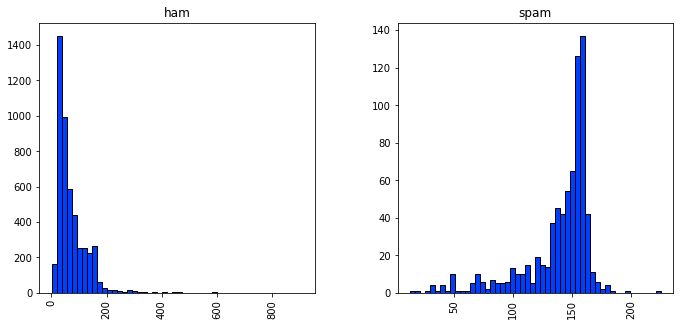

In [6]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [7]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [8]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [9]:
text_feat = text_feat.apply(text_process)

In [10]:
vectorizer = TfidfVectorizer("english")

In [11]:
features = vectorizer.fit_transform(text_feat)

In [12]:
labels = LabelEncoder().fit_transform(sms['label'])
labels = labels.reshape(-1,1)

In [13]:
text_feat.shape

(5572,)

In [14]:
features.shape

(5572, 9403)

###  Classifiers and predictions

#### train_valid_split

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=111)

### Apply gcForest

In [16]:
import sys
sys.path.append("..") 
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json

In [17]:
def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = 111
    ca_config["max_layers"] = 10
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = 2
    ca_config["estimators"] = []
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 31, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 31, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "MultinomialNB", "alpha": 0.2})
    ca_config["estimators"].append({"n_folds": 5, "type": "MultinomialNB", "alpha": 0.2})

    config["cascade"] = ca_config
    return config

In [18]:
import time

In [19]:
config = get_toy_config()
gc = GCForest(config)

# features_train 为 ndarray，labels_train 维度为 (n_samples, )，而不是(n_samples, 1)
features_train = features_train.toarray()
labels_train = labels_train.reshape(-1)

since = time.time()
gc.fit_transform(features_train, labels_train)

time_elapsed = time.time() - since

# gc.fit_transform(features_train, labels_train, features_test, labels_test)

[ 2019-04-22 20:06:58,532][cascade_classifier.fit_transform] X_groups_train.shape=[(3900, 9403)],y_train.shape=(3900,),X_groups_test.shape=no_test,y_test.shape=no_test
[ 2019-04-22 20:06:58,794][cascade_classifier.fit_transform] group_dims=[9403]
[ 2019-04-22 20:06:58,795][cascade_classifier.fit_transform] group_starts=[0]
[ 2019-04-22 20:06:58,796][cascade_classifier.fit_transform] group_ends=[9403]
[ 2019-04-22 20:06:58,797][cascade_classifier.fit_transform] X_train.shape=(3900, 9403),X_test.shape=(0, 9403)
[ 2019-04-22 20:06:58,975][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(3900, 9403), X_cur_test.shape=(0, 9403)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[ 2019-04-22 20:07:03,064][kfold_wrapper.log_eval_m

[ 2019-04-22 20:08:18,897][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_1.predict)=98.85%
[ 2019-04-22 20:08:20,889][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_2.predict)=97.95%
[ 2019-04-22 20:08:22,886][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_3.predict)=99.10%
[ 2019-04-22 20:08:24,898][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_4.predict)=98.97%
[ 2019-04-22 20:08:24,899][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_cv.predict)=98.56%
[ 2019-04-22 20:08:25,151][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_0.predict)=98.72%
[ 2019-04-22 20:08:25,386][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_1.predict)=99.10%
[ 2019-04-22 20:08:25,631][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_2.predict)=98.46%
[ 2019-

[ 2019-04-22 20:09:13,505][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_3 - 5_folds.train_3.predict)=98.33%
[ 2019-04-22 20:09:13,740][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_3 - 5_folds.train_4.predict)=98.72%
[ 2019-04-22 20:09:13,741][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_3 - 5_folds.train_cv.predict)=98.56%
[ 2019-04-22 20:09:13,742][cascade_classifier.calc_accuracy] Accuracy(layer_4 - train.classifier_average)=98.54%
[ 2019-04-22 20:09:13,743][cascade_classifier.fit_transform] [Result][Optimal Level Detected] opt_layer_num=2, accuracy_train=98.62%, accuracy_test=0.00%


In [20]:
print('Training complete in {:.0f}m {:.4f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 

Training complete in 2m 15.2825s


In [23]:
import pickle
# dump
with open("../pkl/sms-gc.pkl", "wb") as f:
    pickle.dump(gc, f, pickle.HIGHEST_PROTOCOL)
    
# # load
# with open("../pkl/2018_gc.pkl", "rb") as f:
#     gc = pickle.load(f)